In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

# 1. Подготовка данных

В качестве целевой переменной берем столбец `total_cases`. В качестве трейна берем первые 50 дней, начиная с 3 марта 2020, оставшиеся дни отправляем в тест.

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [3]:
data = data[data['location'] == 'Russia']
data.date = pd.to_datetime(data.date)
data = data[data.date >= pd.to_datetime('2020-03-03')]
target = data['total_cases'].values#.astype(int)
# target2 = data['new_cases'].apply(lambda x: x + 1 if x == 0 else x).values.astype(int)
x = np.arange(1, target.shape[0] + 1, dtype=float).reshape(-1, 1)

target_train = target[:50]
x_train = x[:50]

target_test = target[50:]
x_test = x[50:]

# 2. Экспоненциальная модель

Построим графики целевых переменных на трейне и тесте.

In [4]:
def plot_target(x, y, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y)
    plt.title(title, fontsize=20)
    plt.xlabel('day', fontsize=15)
    plt.ylabel(title, fontsize=15)
    plt.grid()

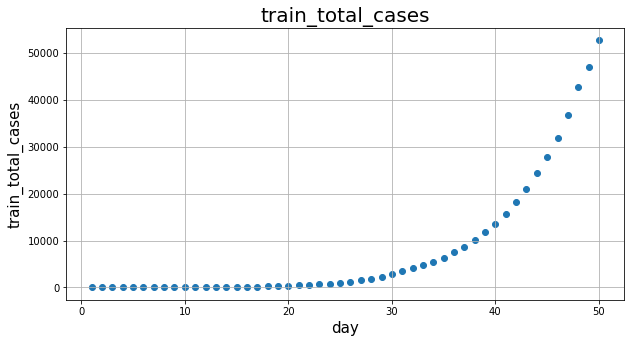

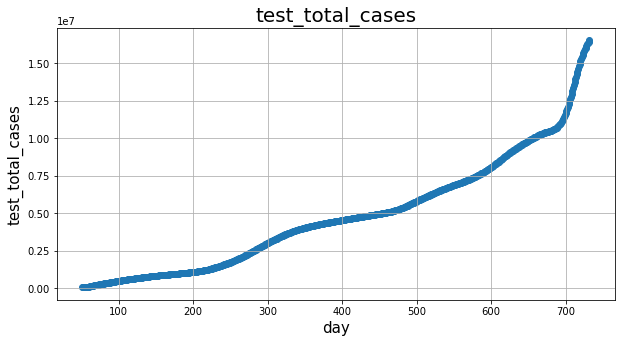

In [5]:
plot_target(x_train, target_train, 'train_total_cases')
plot_target(x_test, target_test, 'test_total_cases')

### 2.1 Обучение линейной регрессии.

Обучим модель с экспоненциальным ростом числа заболевших:

$$
y = exp(w_0 + x*w_1)
$$

$$
y - \text{число заболевших} \\
x - \text{номер текущего дня}
$$

Для этого возвем логарифм от правой и левой частей выражения:

$$
ln(y) = ln(exp(w_0 + x*w_1)) \\
ln(y) = w_0 + x*w_1
$$

Таким образом, необходимо обучить обычную линейную регрессию на предсказание $ln(y)$.


In [97]:
model_exp = LinearRegression().fit(x_train, np.log(target_train))

In [98]:
pred_train_exp = np.exp(model_exp.predict((x_train)))
pred_test_exp = np.exp(model_exp.predict((x_test)))

In [135]:
def plot_target(x, y, pred, title):
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for i in range(2):
        if i == 0:
            ax[i].set_title(title, fontsize=20)
            ax[i].scatter(x, y, label='true values', c='b')
            ax[i].plot(x, pred, label='prediction', c='r')
        else:
            ax[i].set_title(title + '_log_scale', fontsize=20)
            ax[i].scatter(x, np.log(y), label='true values', c='b')
            ax[i].plot(x, np.log(pred), label='prediction', c='r')
        ax[i].set_ylabel(title, fontsize=15)
        ax[i].set_xlabel('day', fontsize=15)
        ax[i].grid()
        ax[i].legend()

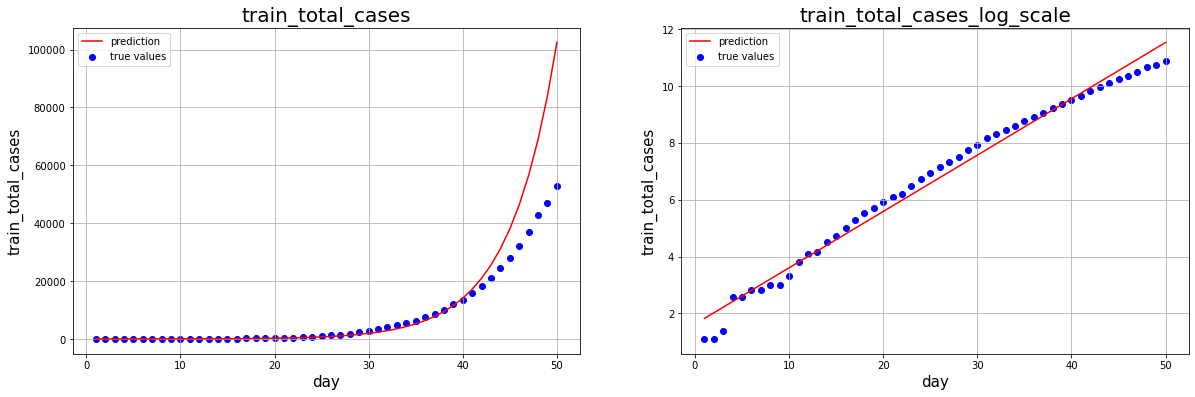

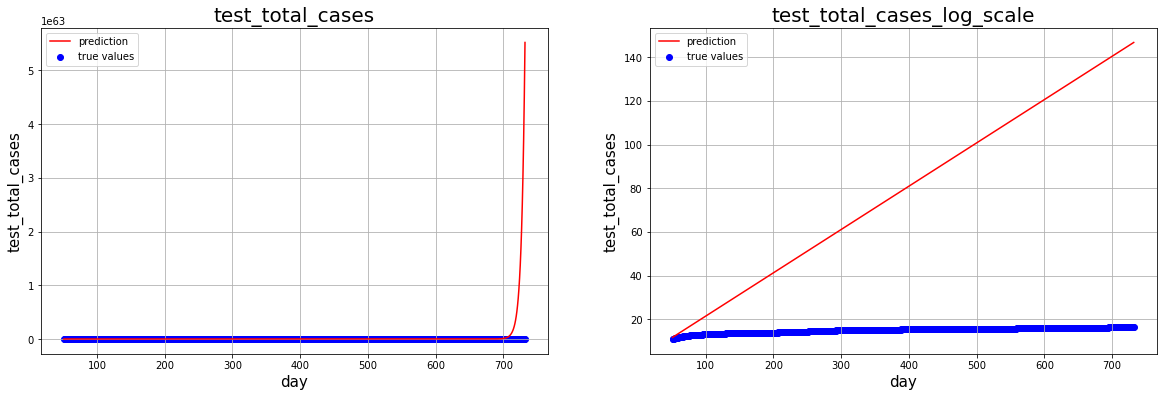

In [136]:
plot_target(x_train, target_train, pred_train_exp, 'train_total_cases')
plot_target(x_test, target_test, pred_test_exp, 'test_total_cases')

Видно, что модель на небольших $x$ неплохо описывает данные, однако дальше экспоненциально растет и совершенно не соотносится с данными, особенно на тесте.

### 2.2 Поиск апостериорного распределения.

Апостериорное распределение задается как произведение априорного распределния и правдоподобия, поэтому сначала определим их.

Априорное распределение зададим как нормальное распределение с параметрами:

$$
\mu = 0 \\
\Sigma = \begin{bmatrix}4 & 0 \\ 0 & 4 \end{bmatrix}
$$

In [48]:
proir_mu = np.array([0, 0]) 
proir_sigma = 2 * np.array([[1, 0], [0, 1]])
w_0 = model_exp.intercept_
w_1 = model_exp.coef_
z_model_exp = multivariate_normal.pdf([w_0, w_1], mean=proir_mu, cov=proir_sigma)
print(f'Вероятность весов модели в соотвествии с априорным распределением: {z_model_exp:.5f}')

Вероятность весов модели в соотвествии с априорным распределением: 0.04081


Посэмплируем прямые из этого априорного распределения.

In [172]:
def sample_lines(mu, sigma, x, y, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    for i in range(2):
        if i == 0:
            ax[i].scatter(x, y, label='true values')
            ax[i].set_ylim(0, 100000)
            ax[i].set_title('sampled_from_prior', fontsize=20)
            for w in my_w:
                ax[i].plot(x, np.exp(w[0] + w[1]*x), 'k-', lw=0.5)
        else:
            ax[i].scatter(x, np.log(y), label='true values')
            ax[i].set_ylim(0, 20)
            ax[i].set_title('sampled_from_prior_log_scale', fontsize=20)
            for w in my_w:
                ax[i].plot(x, w[0] + w[1]*x, 'k-', lw=0.5)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel('y', fontsize=15)
        ax[i].grid()
        ax[i].legend(loc='upper right')

<Figure size 864x432 with 0 Axes>

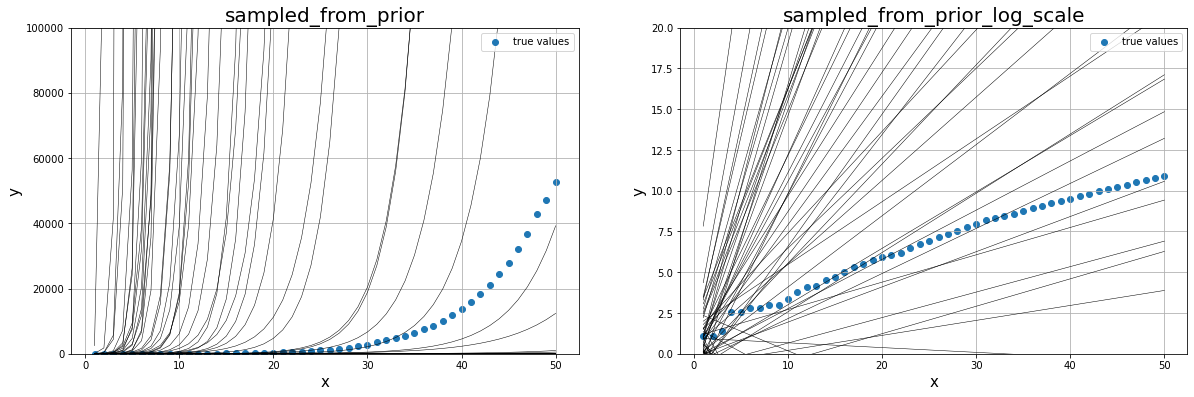

In [174]:
plt.figure(figsize=(12, 6))
sample_lines(proir_mu, proir_sigma, x_train, target_train, 100)

Получаем какой-то набор экспонент никак не соотносящихся с данными. Правдоподобие $i$-го объекта тоже зададим нормальным распределением с параметрами:

$$
\mu = w_0 + w_1x_i\\
\sigma^2 - \text{дисперсия шума, которую можно оценить, используя обученную модель}
$$

Дисперсию необходимо оценивать в логарифмической шкале, так как наша линейная модель предсказывает $ln(y)$.

In [163]:
std_noise = np.std(np.log(target_train) - np.log(pred_train_exp))

Теперь путем перемножения априорного распределения и правдоподобия всех точек датасета получим параметры апостериорного распределения.

In [164]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    x_matrix = np.array([[1, x[0]]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix))
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.log(np.array([y]))))
    return mu_n, sigma_n

In [175]:
post_mu, post_sigma = proir_mu, proir_sigma.copy()
for x, y in zip(x_train, target_train):
    post_mu, post_sigma = bayesian_update(apost_mu, apost_sigma, x, y, std_noise)

### 2.3 Предсказательное распределение 

Теперь посемплируем множество экспонент из получившегося распределения. MAP апостериорного распределения является $\mu$, так как мы взяли нормальное распределение в качестве апостериорного.

In [258]:
def sample_from_posterior(mu, sigma, x, y, pred, limits, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    fig, ax = plt.subplots(1, 2, figsize=(22, 7))
    for i in range(2):
        if i == 0:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x, np.exp(w[0] + w[1]*x), 'aqua', label='sampled')
                else:
                    ax[i].plot(x, np.exp(w[0] + w[1]*x), 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x, y, label='true values')
            ax[i].plot(x, pred, c='r', label='model prediction')
            ax[i].plot(x, np.exp(mu[0] + mu[1] * x), c='orange', label='MAP')
            ax[i].set_ylim(0, limits[0])
            ax[i].set_title('sampled_from_posterior', fontsize=20)
        else:
            for j, w in enumerate(my_w):
                if j == 0:
                    ax[i].plot(x, w[0] + w[1]*x, 'aqua', label='sampled')
                else:
                    ax[i].plot(x, w[0] + w[1]*x, 'aqua', lw=0.3, alpha=0.4)
            ax[i].scatter(x, np.log(y), label='true values')
            ax[i].plot(x, np.log(pred), c='r', label='model prediction')
            ax[i].plot(x, mu[0] + mu[1] * x, c='orange', label='MAP')
            ax[i].set_ylim(0, limits[1])
            ax[i].set_title('sampled_from_posterior_log_scale', fontsize=20)
        ax[i].set_xlabel('x', fontsize=15)
        ax[i].set_ylabel('y', fontsize=15)
        ax[i].grid()
        ax[i].legend(fontsize=15)

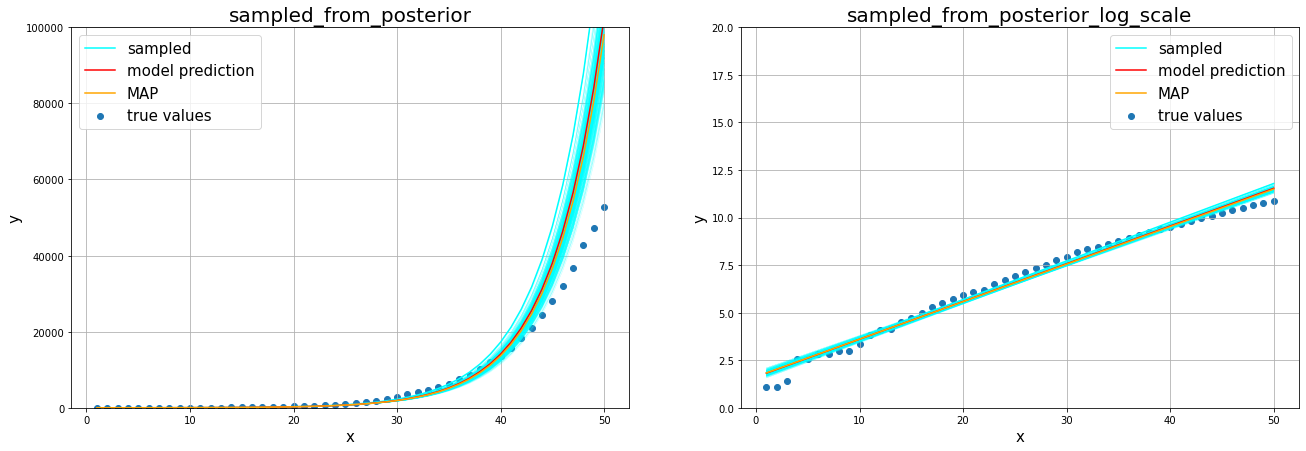

In [259]:
limits = [1e5, 20]
sample_from_posterior(post_mu, post_sigma, x_train, target_train, pred_train_exp, limits, n=400)

Таким образом, мы получили апостериорное распределение с МАР, совпадающим с обученной моделью. Также видно, что с увеличением $x$ увеличивается разброс $y$, то есть модель меньше уверена в предсказаниях.

Теперь попробуем сделать предсказания, для этого сэмплируем экспоненты и на них сделаем предсказания на тесте.

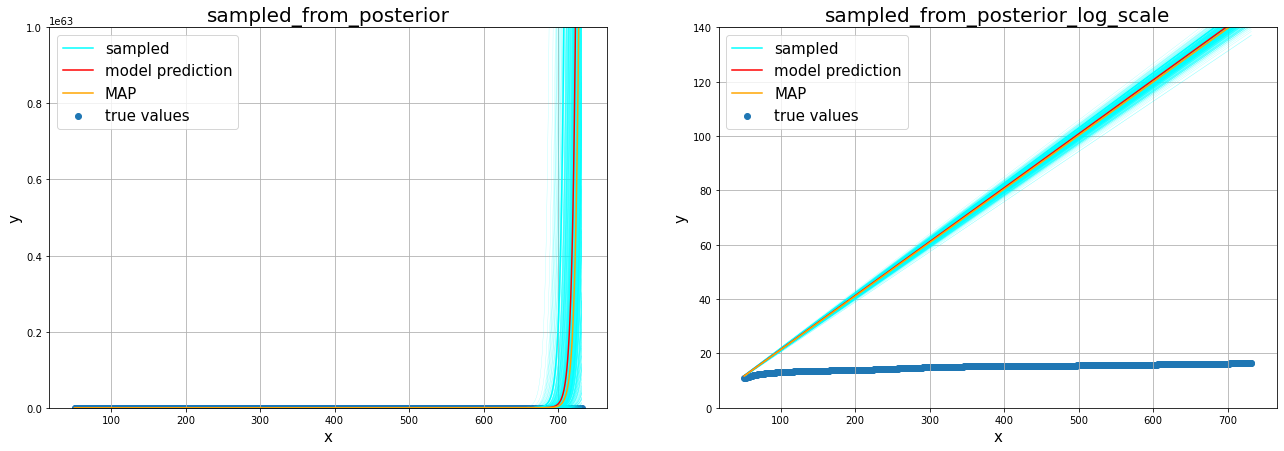

In [261]:
limits = [1e63, 140]
sample_from_posterior(post_mu, post_sigma, x_test, target_test, pred_test_exp, limits, n=400)

Очевидно, что здесь ситуация будет такой же плачевной, как и с обученной моделью. Экспоненциальная модель, которую мы предположили, обладает плохой предсказательной способностью.